## Model Evaluation & Analysis
Here we evaluate the final Decision Tree model, compare it with Random Forest and Categorical NB, and reflect on strengths, limitations, and potential risks.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_curve, auc
import joblib

In [29]:
X_train = joblib.load('models/X_train_final.pkl')
X_test = joblib.load('models/X_test_final.pkl')
y_train = joblib.load('models/y_train_encoded.pkl')
y_test = joblib.load('models/y_test_encoded.pkl')

**Re-training all three models**

In [30]:
#Training Decision Tree with the best hyperparameters
params = {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
dt_model = DecisionTreeClassifier(random_state=42, **params)
dt_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_nb = nb_model.predict(X_test)

In [31]:
models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'Categorical NB': nb_model
}

In [32]:
TARGET_NAMES = ['edible', 'poisonous']

**Model Evaluation and Analysis**

In [33]:
print("\n--- Classification Report (Decision Tree) ---")
print(classification_report(y_test, y_pred_dt, target_names=TARGET_NAMES))

print("\n--- Classification Report (Random Forest) ---")
print(classification_report(y_test, y_pred_rf, target_names=TARGET_NAMES))

print("\n--- Classification Report (Categorical NB) ---")
print(classification_report(y_test, y_pred_nb, target_names=TARGET_NAMES))


--- Classification Report (Decision Tree) ---
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       842
   poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


--- Classification Report (Random Forest) ---
              precision    recall  f1-score   support

      edible       1.00      1.00      1.00       842
   poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625


--- Classification Report (Categorical NB) ---
              precision    recall  f1-score   support

      edible       0.90      0.99      0.94       842
   poisonous       0.98      0.88      0.93       783

    accuracy                           0

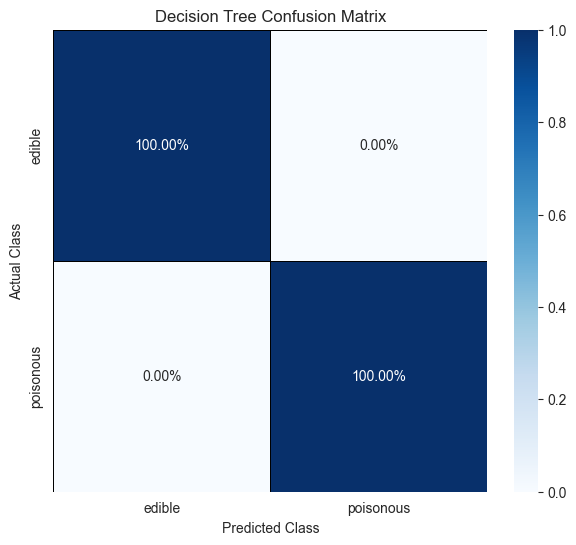

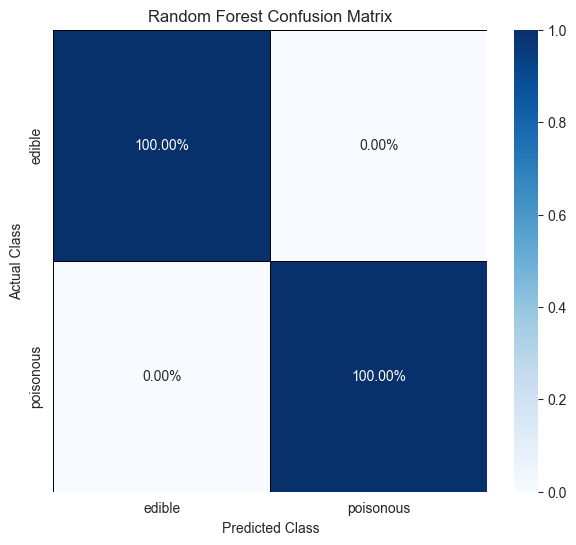

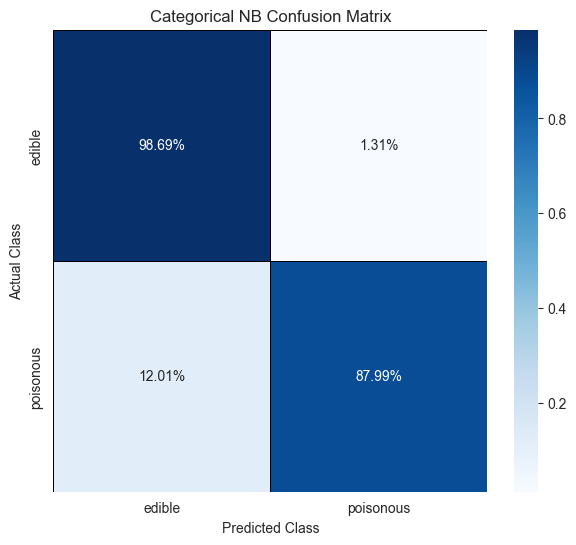

In [34]:
# Display confusion matrix for each model
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    cm_percent = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=TARGET_NAMES, yticklabels=TARGET_NAMES,
                linewidths=.5, linecolor='black')
    plt.title(f'{name} Confusion Matrix')
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    plt.show()

In [35]:
# this is for api
joblib.dump(dt_model, "models/dt_model.pkl")

['models/dt_model.pkl']

**Validation Curve**

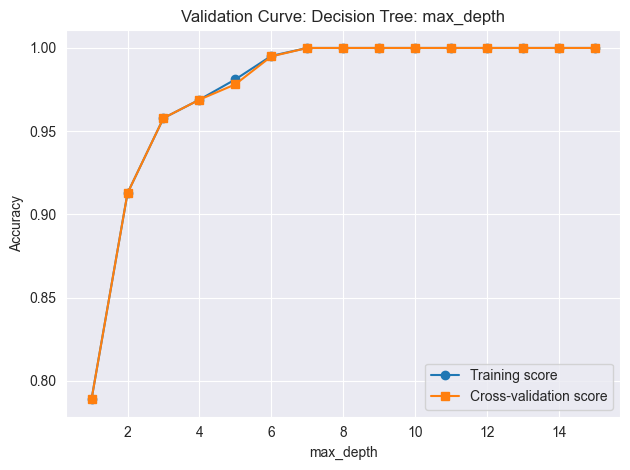

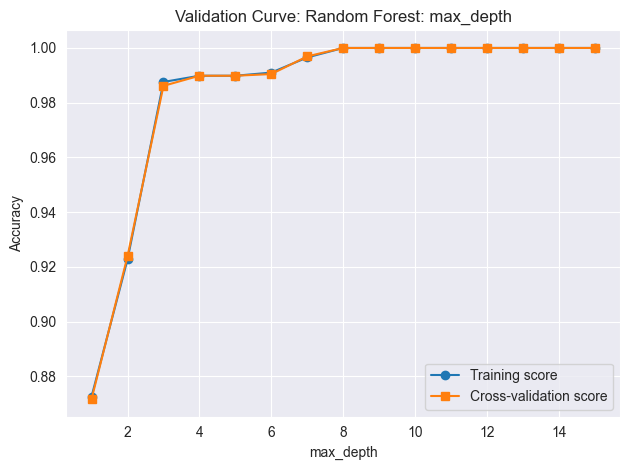

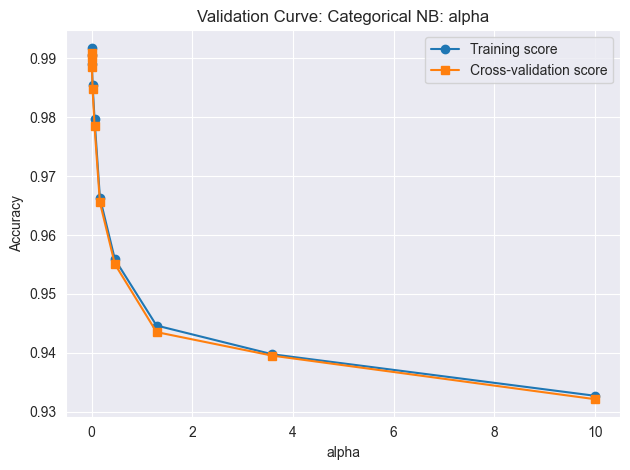

In [36]:
model_params = [
    (DecisionTreeClassifier, "max_depth", np.arange(1, 16), "Decision Tree: max_depth"),
    (RandomForestClassifier, "max_depth", np.arange(1, 16), "Random Forest: max_depth"),
    (CategoricalNB, "alpha", np.logspace(-3, 1, 10), "Categorical NB: alpha"),
]

for model_class, param_name, param_range, title in model_params:
    train_scores, test_scores = validation_curve(
        model_class(random_state=42) if 'random_state' in model_class().get_params() else model_class(),
        X_train, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=5,
        scoring="accuracy"
    )
    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training score', marker='o')
    plt.plot(param_range, np.mean(test_scores, axis=1), label='Cross-validation score', marker='s')
    plt.xlabel(param_name)
    plt.ylabel("Accuracy")
    plt.title(f"Validation Curve: {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**ROC (Reciever Operating Characteristic) Curve**

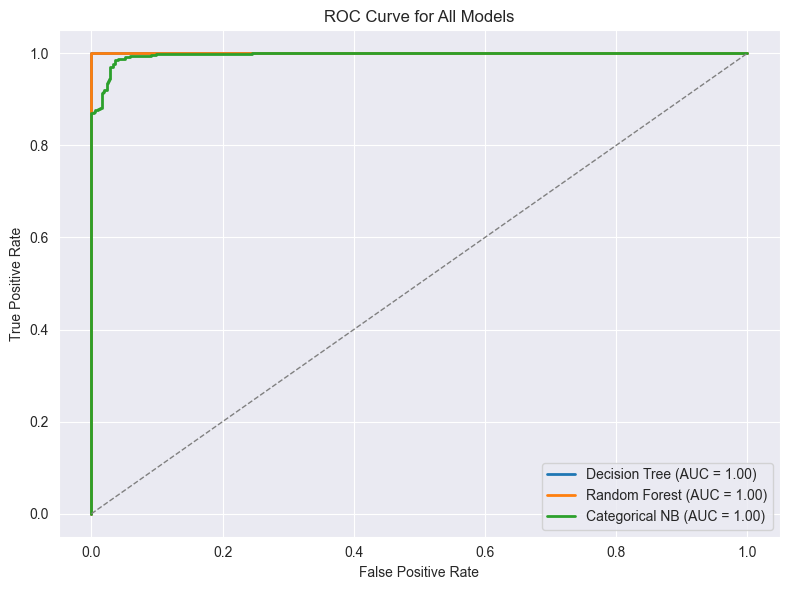

In [37]:
plt.figure(figsize=(8, 6))

for label, model in models.items():
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for All Models")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

**Feature Importance Plot**

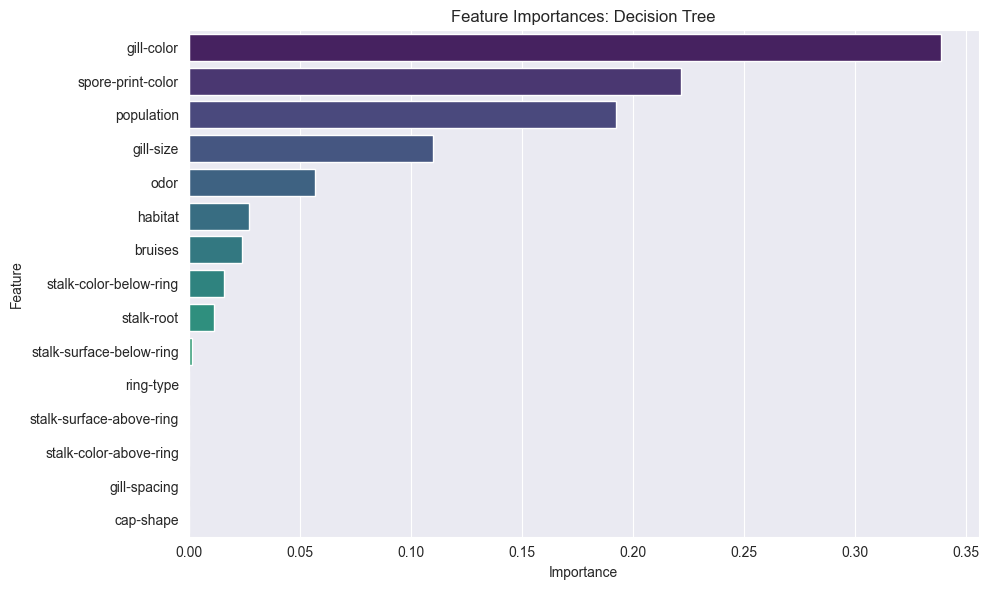

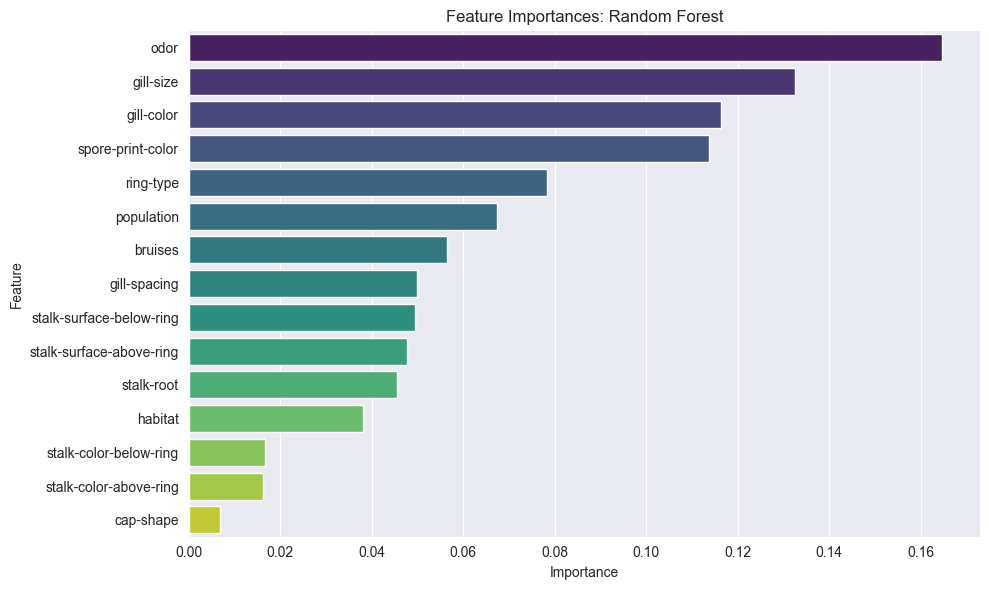

In [26]:
models_ft = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}

for name, model in models_ft.items():
    importances = model.feature_importances_
    feature_names = X_train.columns
    fi_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
    fi_df = fi_df.sort_values("Importance", ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", hue="Feature", data=fi_df, palette="viridis")
    plt.title(f"Feature Importances: {name}")
    plt.tight_layout()
    plt.show()

**Permutation Importance for NB**

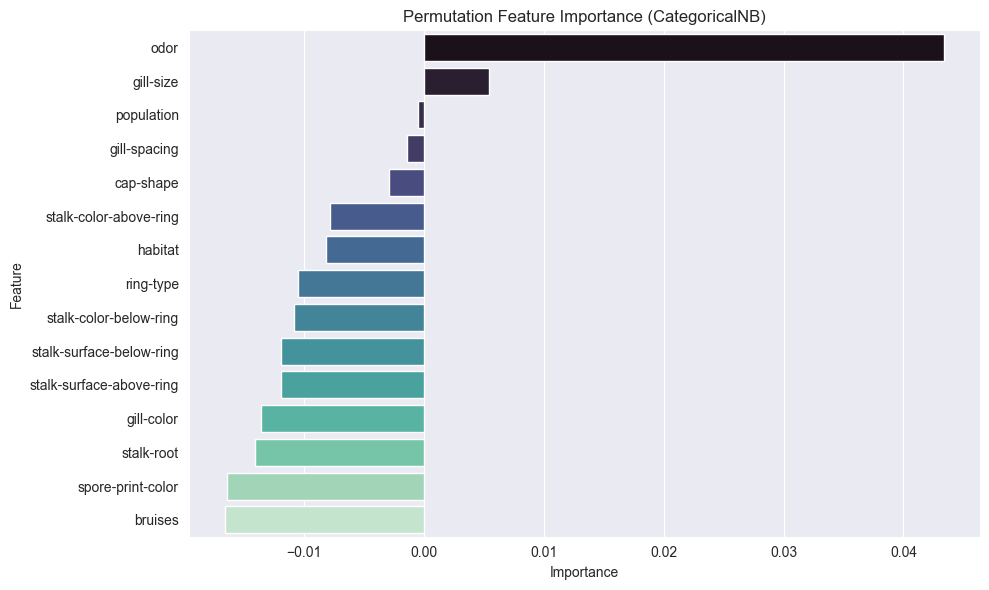

In [27]:
from sklearn.inspection import permutation_importance
result = permutation_importance(nb_model, X_test, y_test, n_repeats=10, random_state=0, n_jobs=-1)
perm_df = pd.DataFrame({"Feature": X_test.columns, "Importance": result.importances_mean})
perm_df = perm_df.sort_values("Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", hue="Feature", data=perm_df, palette="mako")
plt.title("Permutation Feature Importance (CategoricalNB)")
plt.tight_layout()
plt.show()


 **1) Decision Tree (DT)**
<br><br> **STRENGTH:** It's the simplest model. Achieved 100% accuracy with clear, transparent rules. Low computing power needed.
<br> **WEAKNESS:** The perfect 100% score suggests the model might be too tuned to this data, risking failure on new, slightly different real-world data.
<br><br> **2) Random Forest (RF)**
<br><br> **STRENGTH:** As a group of trees, it's generally a very stable and dependable model that handles data noise well.
<br> **WEAKNESS:** Does not perform better than the DT, but is harder to explain and uses more computing power. We reject it because it's unnecessarily complicated.
<br><br> **3) Categorical NB**
<br><br> **STRENGTH:** Quickest model to train, making it a good starting point.
<br> **WEAKNESS:** It failed because it assumes features don't influence each other, which is not true for real-world data. Also, its performance is lower than other models have (≈96%). Also, if new feature appears in test data, the model will assign zero probability so we'll need to apply smoothing to ensure that our mushrooms with new ring type are recognized.

**Overall Reflection**
- Cross-validation shows consistent DT performance
- Confusion matrix confirms no misclassifications
- Feature importance highlights key drivers (e.g., 'odor', 'spore-print-color')
- Limitation: perfect accuracy could mask overfitting; monitor real-world deployment
- Fairness & bias: not critical here, but ensure generalizability for new data